This notebook uses code adapted from 

Fatiando 
- Uieda, L, Oliveira Jr, V C, Ferreira, A, Santos, H B; Caparica Jr, J F (2014), Fatiando a Terra: a Python package for modeling and inversion in geophysics. figshare. doi:10.6084/m9.figshare.1115194

SimPEG
- Cockett, R., S. Kang, L.J. Heagy, A. Pidlisecky, D.W. Oldenburg (2015, in review), SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications. Computers and Geosciences

In [1]:
# %%file importMag.py
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# import warnings
# warnings.filterwarnings('ignore') # ignore warnings: only use this once you are sure things are working

# from IPython.html.widgets import *
# from fromFatiando import *
# from fromSimPEG import *
# from scipy.constants import mu_0

from importMag import *


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 23 days


In [2]:
%matplotlib inline

In [3]:
def definePrism(dx, dy, dz, depth, susc = 1., x0=0.,y0=0., pinc=0., pdec=0., Einc=90., Edec=0., Bigrf=1e3, Q = 0., rinc = 0., rdec = 0.):
    """
        wrapper on fatiando prism construction
        
        Prism geometry:
            - dx, dy, dz: width, length and height of prism
            - depth : depth to top of prism
            - susc : susceptibility of prism
            - x0, y0 : center of prism in horizontal plane
            - pinc, pdec : inclination and declination of prism
        
        Earth's field:
            - Einc, Edec : inclination and declination of Earth's magnetic field
            - Bigrf : amplitude of earth's field in units of nT
        
        Remnance:
            - Q : Koenigsberger ratio
            - Rinc, Rdec : inclination and declination of remnance in block 
        
    """
    Higrf = Bigrf * 1e-9 / mu_0

    x1, x2 = -dx/2. - x0, dx/2. - x0
    y1, y2 = -dy/2. - y0, dy/2. - y0
    z1, z2 = depth, depth + dz
    Mind = susc*Higrf
    rMag = Q*Mind
    
    # This is a bit of a hack: I am putting all of the parameters we will need later in the 'property' dictionary 
    return fatiandoGridMesh.Prism(x1, x2, y1, y2, z1, z2,{'magnetization': fatiandoUtils.ang2vec(rMag, rinc-pinc, rdec-pdec),'pinc':pinc,'pdec':pdec,'rinc':rinc,'rdec':rdec,'depth':depth,'Einc':Einc,'Edec':Edec,'Mind':Mind})

In [4]:
# define the survey area
nx, ny = 100,100
surveyArea = (-20., 20., -20., 20.)
z = 0. 
shape = (nx,ny)
xp, yp, zp = fatiandoGridMesh.regular(surveyArea,shape, z=z)

In [211]:
def plotObj3D(p,elev,azim):
    
    depth = p.props['depth']
    x1, x2 = p.x1, p.x2
    y1, y2 = p.y1, p.y2
    z1, z2 = p.z1, p.z2
    pinc, pdec = p.props['pinc'], p.props['pdec']
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams.update({'font.size': 13})
    
    ax.set_xlim3d(surveyArea[:2])
    ax.set_ylim3d(surveyArea[2:])
#     ax.set_zlim3d(depth+np.array(surveyArea[:2]))
    ax.set_zlim3d(0., surveyArea[-1]*2)

    xpatch = [x1,x1,x2,x2]
    ypatch = [y1,y2,y2,y1]
    zpatch = [z1,z1,z1,z1]
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))
    zpatch = [z2,z2,z2,z2]
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))
    
    xpatch = [x1,x1,x1,x1]
    ypatch = [y1,y2,y2,y1]
    zpatch = [z1,z1,z2,z2]                                  
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))    
    xpatch = [x2,x2,x2,x2]                                 
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])])) 
    
    xpatch = [x1,x2,x2,x1]
    ypatch = [y1,y1,y1,y1]
    zpatch = [z1,z1,z2,z2]                                  
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))   
    ypatch = [y2,y2,y2,y2]                                 
    xyz = simpegCoordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],fatiandoUtils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])])) 
    
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_zlabel('Depth (m)')
#     ax.plot(xp,yp,z,'.g')

    ax.view_init(elev,azim) 
# plt.show()

# ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b')

In [212]:
def Prism(dx, dy, dz, depth, pinc, pdec, elev, azim):
    p = definePrism(dx, dy, dz, depth,pinc=pinc, pdec=pdec, susc = 1., Einc=90., Edec=0., Bigrf=1e-6)
    return plotObj3D(p, elev, azim)

In [213]:
from IPython.html import widgets

In [214]:
Q1 = interactive(Prism,dx=FloatText(value=5.),dy=FloatText(value=5.), dz=FloatText(value=5.)\
                ,depth=widgets.IntSliderWidget(min=0,max=10,step=1,value=10)
                ,pinc=(-90, 90, 10), pdec=(-90, 90., 10) \
                ,elev=FloatText(value=200), azim=FloatText(value=25))

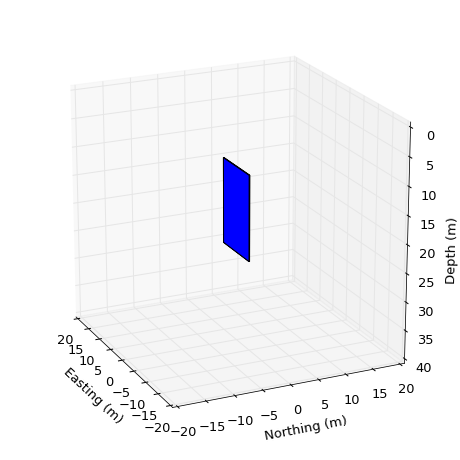

In [215]:
from IPython.display import display
display(Q1)

In [216]:
Q1.kwargs

{'azim': 25.0,
 'depth': 10,
 'dx': 10.0,
 'dy': 1.0,
 'dz': 5.0,
 'elev': 200.0,
 'pdec': 0.0,
 'pinc': 0}

In [188]:
def getField(p,comp='tf',irt='induced'):
    
    pinc,pdec = p.props['pinc'], p.props['pdec']
    Einc, Edec = p.props['Einc'], p.props['Edec']
    rinc,rdec = p.props['rinc'], p.props['rdec']
    Mind = p.props['Mind']
    
    x1, x2 = p.x1, p.x2
    y1, y2 = p.y1, p.y2
    z1, z2 = p.z1, p.z2
    
    XYZ = np.vstack([xp,yp,zp]).T
    XYZ = simpegCoordUtils.rotatePointsFromNormals(XYZ, fatiandoUtils.ang2vec(1., rinc, rdec), np.r_[1.,0.,0.], np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.] )

    xp_eval, yp_eval, zp_eval = XYZ[:,0], XYZ[:,1], XYZ[:,2]

    if irt is 'induced' or irt is 'total':
        if comp is 'bx': fieldi = fatiandoMagPrism.bx(xp_eval,yp_eval,zp_eval,[p],fatiandoUtils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'by': fieldi = fatiandoMagPrism.by(xp_eval,yp_eval,zp_eval,[p],fatiandoUtils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'bz': fieldi = fatiandoMagPrism.bz(xp_eval,yp_eval,zp_eval,[p],fatiandoUtils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'tf': fieldi = fatiandoMagPrism.tf(xp_eval,yp_eval,zp_eval,[p],Einc-pinc,Edec-pdec,fatiandoUtils.ang2vec(Mind, Einc-pinc, Edec-pdec))
            
    if irt is 'remnant' or irt is 'total':
        if comp is 'bx': fieldr = fatiandoMagPrism.bx(xp_eval,yp_eval,zp_eval,[p])
        elif comp is 'by': fieldr = fatiandoMagPrism.by(xp_eval,yp_eval,zp_eval,[p])
        elif comp is 'bz': fieldr = fatiandoMagPrism.bz(xp_eval,yp_eval,zp_eval,zp,[p])
        elif comp is 'tf': fieldr = fatiandoMagPrism.tf(xp_eval,yp_eval,zp_eval,[p],Einc-pinc,Edec-pdec)
        
    if irt is 'induced':
        return fieldi
    elif irt is 'remnant':
        return fieldr
    elif irt is 'total':
        return fieldi + fieldr

In [138]:
def plotMag(p, comp='tf'):
    fig,ax = plt.subplots(1,2, figsize = (9, 4))
    plt.rcParams.update({'font.size': 13})

    fieldi = getField(p,comp,'induced')
    fieldr = getField(p,comp,'remnant')
    fieldt = fieldi + fieldr
    fig.canvas.draw()
    im = ax[0].contourf(xp.reshape(shape),yp.reshape(shape),fieldi.reshape(shape), 20)
    ax[0].axis('equal')
    # ax[0].axis('tight')

    ax[0].set_xlabel('Easting (m)')
    ax[0].set_ylabel('Northing (m)')
    fig.colorbar(im,ax=ax[0],label=comp+' (nT)')

    plotDataPoints = False
    if plotDataPoints:
        ax[0].plot(xp,yp,'.',color='k')

    # plot a line of data
    xline = 0.
    xvec = xp.reshape(shape)[:,0]
    ind = np.min(np.nonzero(abs(xvec - xline) == abs(xvec - xline).min()))
    ax[0].plot(xp.reshape(shape)[ind,:],yp.reshape(shape)[ind,:],'k',linewidth=1.4)

    ax[1].plot(yp.reshape(shape)[ind,:],fieldi.reshape(shape)[ind,:],'o-',markersize=4)
    ax[1].plot(yp.reshape(shape)[ind,:],fieldr.reshape(shape)[ind,:],'o-',markersize=4)
    ax[1].plot(yp.reshape(shape)[ind,:],fieldt.reshape(shape)[ind,:],'o-',markersize=4)

    ax[1].grid(which='both')
    ax[1].set_ylabel(comp +' (nT)')
    ax[1].set_xlabel('Northing (m)')
#     ax[1].legend(['induced','remanent','total'],loc='best')

    plt.tight_layout()
    
#     return fig,ax

In [191]:
plotMagprsm = lambda dx, depth, susc, Einc, Edec, Bigrf, Q, rinc, rdec: plotMag(definePrism(dx=dx, dy=dx, dz=100., depth = depth, susc = susc, Einc= Einc, Edec= Edec, Bigrf=Bigrf, Q=Q, rinc=rinc, rdec=rdec))
interact(plotMagprsm, dx = fix(Q1.kwargs['dx']), depth = fix(Q1.kwargs['depth']), susc = (0.,200.,1.), Einc = (0.,180.,1.), Edec = (-180.,180.,1.) , Bigrf=FloatText(value=100), Q = (0., 2., 0.1), rinc=FloatText(value=0.), rdec=FloatText(value=0.))#,comp=['tf','bx','by','bz'] )

NameError: name 'fix' is not defined

In [19]:
test

<function __main__.<lambda>>